In [1]:
import random
import gym
import matplotlib.pyplot as plt
import numpy as np

env = gym.make("FrozenLake-v0")
env.render()


SFFF
FHFH
FFFH
HFFG


In [18]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import random

In [20]:
input = torch.randn(3, 5, requires_grad=True)
target = torch.empty(3, dtype=torch.long).random_(5)

In [21]:
input.shape

torch.Size([3, 5])

In [22]:
target.shape

torch.Size([3])

In [2]:
def init_q():
    q_values = {}
    for s in range(0, env.observation_space.n):
        for a in range(0, env.action_space.n):
            q_values[(s, a)] = 0
    return q_values

In [3]:
def play_episode_mc_control(q_values, epsilon):
    # current state we are in
    state = env.reset()
    done = False
    r_s = [] # rewards after each step of episode
    s_a = [] # state|action pairs of episode
    # apply policy
    while not done:
        action = choose_action(q_values, state, epsilon)

        s_a.append((state, action))
        state, reward, done, _ = env.step(action)
        r_s.append(reward)
    return s_a, r_s

In [4]:
# TODO update Q-values with TD prediction after every step
# TODO update policy after every step
def play_episode_SARSA(q_values, epsilon):
    # current state we are in
    state = env.reset()
    done = False
    r_s = [] # rewards after each step of episode
    s_a = [] # state|action pairs of episode
    
    # choose first action
    action = choose_action(q_values, state, epsilon)
    
    while not done:
        s_a.append((state, action))
        state_bar, reward, done, _ = env.step(action)
        r_s.append(reward)
        
        # get A' for S' to calculate q_values
        action_bar = choose_action(q_values, state_bar, epsilon)
        
        # update q-values
        q_values[(state, action)] += 0.3 * (reward + q_values[(state_bar, action_bar)] - q_values[(state, action)])
        
        state = state_bar
        action = action_bar
        
    return s_a, r_s

In [5]:
# TODO update q-values with max(Q(S',A)) instead of Q(S',A')
def play_episode_QLearning(q_values, epsilon):
    # current state we are in
    state = env.reset()
    done = False
    r_s = [] # rewards after each step of episode
    s_a = [] # state|action pairs of episode
    
    
    
    while not done:# choose first action
        action = choose_action(q_values, state, epsilon)
        s_a.append((state, action))
        state_bar, reward, done, _ = env.step(action)
        r_s.append(reward)
        
        # get A' for S' to calculate q_values
        action_bar = choose_action(q_values, state_bar, epsilon)
        
        # update q-values
        q_values[(state, action)] += 0.3 * (reward + max([q_values[(state_bar, a)] for a in range(0, env.action_space.n)]) - q_values[(state, action)])
        
        state = state_bar
        #action = action_bar
        
    return s_a, r_s

In [6]:
# pick highest q value action or if you slip, pick random action
def choose_action(q_values, state, epsilon):
    if random.random() > epsilon:
        relevant_qs = [q_values[(state, a)] for a in range(0, env.action_space.n)]
        # there can be more than one best action
        best_actions_indexes = [i for i, v in enumerate(relevant_qs) if v == max(relevant_qs)]
        # in this case randomly choose one of them
        return random.choice(best_actions_indexes)
    else:
        return random.randint(0, 3)

In [7]:
no_executions = 100
no_episodes = 1000

epsilons = [0.01, 0.1, 0.5, 1.0]

In [8]:
# MC Control
plot_data_mc_control = []
for e in epsilons:
    rewards = np.zeros(no_executions * no_episodes)
    rewards = rewards.reshape(no_executions, no_episodes)
    for j in range(0, no_executions):
        q_values = init_q()
        for i in range(0, no_episodes):
            s, r = play_episode_mc_control(q_values, epsilon=e)
            rewards[j][i] = sum(r)

            # update q-values
            for i2, q in enumerate(s):
                return_i = sum(r[i2:]) # empirical return for episode

                # running mean with alpha = 0.3 and no discount factor
                q_values[q] += 0.3 * (return_i - q_values[q])

    rewards = rewards.mean(axis=0)
    plot_data_mc_control.append(np.cumsum(rewards))

In [9]:
plot_data_SARSA = []
for e in epsilons:
    rewards = np.zeros(no_executions * no_episodes)
    rewards = rewards.reshape(no_executions, no_episodes)
    for j in range(0, no_executions):
        q_values = init_q()
        for i in range(0, no_episodes):
            s, r = play_episode_SARSA(q_values, epsilon=e)
            rewards[j][i] = sum(r)

    rewards = rewards.mean(axis=0)
    plot_data_SARSA.append(np.cumsum(rewards))

In [10]:
plot_data_QLearning = []
for e in epsilons:
    rewards = np.zeros(no_executions * no_episodes)
    rewards = rewards.reshape(no_executions, no_episodes)
    for j in range(0, no_executions):
        q_values = init_q()
        for i in range(0, no_episodes):
            s, r = play_episode_QLearning(q_values, epsilon=e)
            rewards[j][i] = sum(r)

    rewards = rewards.mean(axis=0)
    plot_data_QLearning.append(np.cumsum(rewards))

In [11]:
best_epsilons = [0.01, 0.1, 0.1]
algorithm = ["MC_Control", "SARSA", "QLearning"]
plot_data = [plot_data_mc_control[0], plot_data_SARSA[1], plot_data_QLearning[1]]

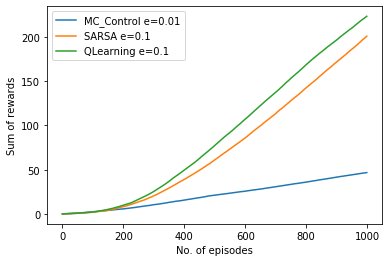

In [12]:
plt.figure()
plt.xlabel("No. of episodes")
plt.ylabel("Sum of rewards")
for i, eps in enumerate(best_epsilons):
    plt.plot(range(0, no_episodes), plot_data[i], label=algorithm[i] + " e=" + str(eps))
plt.legend()
plt.show()